Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D regression example based on DenseNet

This tutorial shows an example of 3D regression task based on DenseNet and array format transforms.

Here, the task is given to predict the ages of subjects from MR imagee.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_regression/densenet_training_array.ipynb)

## Setup environment

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

## Setup imports

In [2]:
import logging
import os
import sys
import shutil
import tempfile

import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    EnsureChannelFirstd,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
from monai.networks.nets import Regressor

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# print_config()

## Setup data directory

In [3]:
import pickle
import numpy as np
dataset_names=["/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/abcd/paths_and_info_flexpath.pkl",
               "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/adni_t1/paths_and_info_flexpath.pkl",
               "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/hcp_ag_t1/paths_and_info_flexpath.pkl",
               "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/hcp_dev_t1/paths_and_info_flexpath.pkl",
               "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/hcp_ya_mpr1/paths_and_info_flexpath.pkl",
               "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/metadata/ppmi_t1/paths_and_info_flexpath.pkl"]
train_images=[]
train_ages=[]
val_images=[]
val_ages=[]
for dataset_name in dataset_names:
    with open(dataset_name, 'rb') as file:
        data = pickle.load(file)
        
        # Convert paths and ages to lists if they are NumPy arrays
        train_new_images = data['train']['paths'].tolist() if isinstance(data['train']['paths'], np.ndarray) else data['train']['paths']
        train_new_ages = data['train']['age'].tolist() if isinstance(data['train']['age'], np.ndarray) else data['train']['age']
        
        val_new_images = data['val']['paths'].tolist() if isinstance(data['val']['paths'], np.ndarray) else data['val']['paths']
        val_new_ages = data['val']['age'].tolist() if isinstance(data['val']['age'], np.ndarray) else data['val']['age']
        
        # Append new data to existing lists
        if not train_images:  # More Pythonic way to check if the list is empty
            # Direct assignment for the first file
            train_images = train_new_images
            train_ages = train_new_ages
            val_images = val_new_images
            val_ages = val_new_ages
        else:
            # Concatenation for subsequent files
            train_images += train_new_images
            train_ages += train_new_ages
            val_images += val_new_images
            val_ages += val_new_ages
        
        # Debug output to check the results
        print(train_images[-1])  # Print the last path
        
prefix = "/scr/fangruih/stru/"
train_images = [prefix + train_image for train_image in train_images]
val_images = [prefix + val_image for val_image in val_images]

print(len(train_images))  # Print the total number of paths loaded
print(len(train_ages))  # Print the total number of paths loaded

print(len(val_images))  # Print the total number of paths loaded
print(len(val_ages))  # Print the total number of paths loaded


t1/abcd/sub-NDARINVJLFDX0WJ/ses-2YearFollowUpYArm1/anat/sub-NDARINVJLFDX0WJ_ses-2YearFollowUpYArm1_run-01_T1w_nrm_crp.npy
t1/adni/035_S_0292/MT1__GradWarp__N3m/2013-05-01_14_31_36.0/I371451/ADNI_035_S_0292_MR_MT1__GradWarp__N3m_Br_20130507153329708_S188641_I371451_nrm_crp.npy
t1/hcp_aging/HCA6633069_V1_MR/T1w_nrm_crp.npy
t1/hcp_dev/HCD0797877_V1_MR/T1w_nrm_crp.npy
t1/hcp_ya_mpr1/169343/169343_3T_T1w_MPR1_nrm_crp.npy
t1/ppmi/51689/T1-anatomical/2015-12-08_14_41_38.0/I696900/PPMI_51689_MR_T1-anatomical_Br_20160429191726566_S360889_I696900_nrm_crp.npy
21051
21051
6015
6015


In [4]:
import numpy as np

# Path to the .npy file
file_path = "/scr/fangruih/stru/t1/hcp_ya_mpr1/169343/169343_3T_T1w_MPR1_nrm_crp.npy"
# Load the numpy file
data = np.load(file_path)

# Print the dimensions of the loaded data
print("Dimensions of the loaded data:", data.shape)

Dimensions of the loaded data: (1, 160, 192, 176)


In [6]:
import os

# Specify the directory containing the files
directory = "/simurgh/u/fangruih/monai-tutorials/generative/3d_ldm/output/t1_all/age/20240828/"

# Define the newage you want to filter by (as an integer)
selected_newage = 80  # Replace with your specific newage

# Initialize the lists
val_images = []
val_ages = []
ori_ages=[]
new_ages=[]

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".nii") and "newAge_" in filename:
        # Extract the index, oriage, and newage from the filename
        parts = filename.split('_')
        print(parts)
        index = int(parts[1])
        oriage = int(parts[3])
        newage = int(parts[5].split('.')[0])
        # print(index, oriage,newage)
        
        # Check if the newage matches the selected newage
        # if newage == selected_newage:
            # Append the full path to val_images and oriage to val_ages
        val_images.append(os.path.join(directory, filename))
        ori_ages.append(oriage)
        new_ages.append(newage)
        

# val_images now contains the file paths with the selected newage
# val_ages contains the corresponding oriage values
print(val_images)
print(ori_ages)
print(new_ages)



['index', '11', 'oriAge', '77', 'newAge', '60.nii']
['index', '11', 'oriAge', '77', 'newAge', '15.nii']
['index', '1', 'oriAge', '11', 'newAge', '9.nii']
['index', '11', 'oriAge', '77', 'newAge', '77.nii']
['index', '2', 'oriAge', '12', 'newAge', '9.nii']
['index', '1', 'oriAge', '11', 'newAge', '15.nii']
['index', '0', 'oriAge', '9', 'newAge', '60.nii']
['index', '1', 'oriAge', '11', 'newAge', '60.nii']
['index', '0', 'oriAge', '9', 'newAge', '15.nii']
['index', '11', 'oriAge', '77', 'newAge', '82.nii']
['index', '2', 'oriAge', '12', 'newAge', '80.nii']
['index', '2', 'oriAge', '12', 'newAge', '60.nii']
['index', '1', 'oriAge', '11', 'newAge', '11.nii']
['index', '2', 'oriAge', '12', 'newAge', '15.nii']
['index', '1', 'oriAge', '11', 'newAge', '80.nii']
['index', '0', 'oriAge', '9', 'newAge', '80.nii']
['index', '12', 'oriAge', '91', 'newAge', '82.nii']
['index', '9', 'oriAge', '82', 'newAge', '82.nii']
['index', '0', 'oriAge', '9', 'newAge', '9.nii']
['index', '9', 'oriAge', '82', 'n

## Create data loaders

In [7]:
# Define transforms
# train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(channel_dim=0), Resize((148,180,148)), RandRotate90()])
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(channel_dim=3), Resize((148,180,148))])
val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(channel_dim=3),Resize((148,180,148))])

# train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
# val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

# Define nifti dataset, data loader
# check_ds = ImageDataset(image_files=train_images, labels=train_ages, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

# im, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, label, label.shape)

# create a training data loader
# train_ds = ImageDataset(image_files=train_images, labels=train_ages, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=val_images, labels=new_ages, transform=val_transforms)
val_loader =   DataLoader(val_ds, batch_size=1, num_workers=1, pin_memory=pin_memory, shuffle=False)

## Evaluate model 

In [10]:
import sys
import torch
import wandb
import numpy as np
from torch.nn import MSELoss
from torch.optim import Adam
# from torch.utils.tensorboard import SummaryWriter
# from model import Regressor  # Assuming this is your model's import statement.# Initialize wandb
# wandb.init(project="age-regressor")

# Setup the model
model = Regressor(in_shape=[1,148,180,148], out_shape=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2))
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
else:
    device = torch.device("cpu")

# Loss and optimizer
loss_function = MSELoss()
optimizer = Adam(model.parameters(), 1e-4)

# Training settings
val_interval = 1
max_epochs = 1
best_metric = sys.float_info.max

state_dict = torch.load('best_metric_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

model.eval()
labels_list_val = []
outputs_list_val = []
with torch.no_grad():
    val_losses = []
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_images)
        val_loss = loss_function(val_outputs, val_labels.float())
        val_losses.append(val_loss.item())
        # print("val_labels", val_labels)
        # print("val_outputs", val_outputs)
        labels_list_val.extend(val_labels.cpu().numpy())
        outputs_list_val.extend(val_outputs.cpu().numpy())

        # print("val_labels", val_labels)
        # print("val_outputs", val_outputs)
    
    avg_val_loss = sum(val_losses) / len(val_losses)
    print("avg_val_loss", avg_val_loss)



Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


avg_val_loss 840.3396732496178


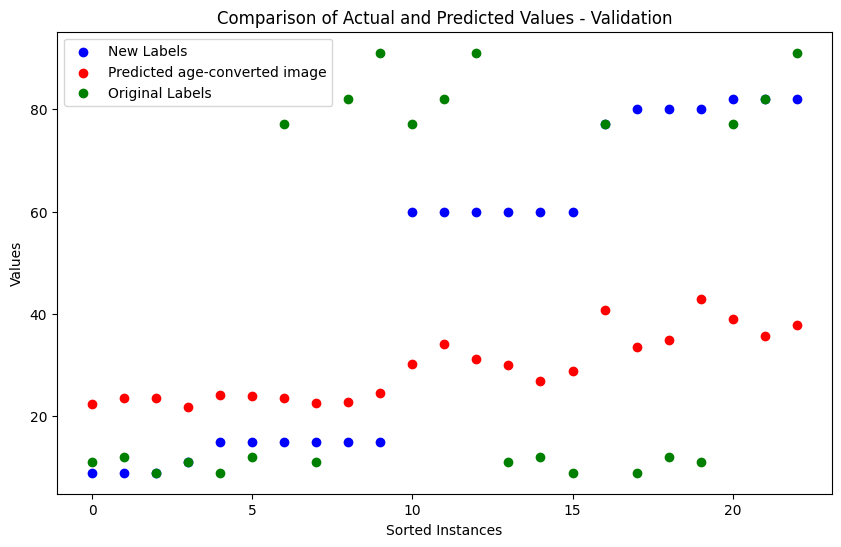

In [11]:
import matplotlib.pyplot as plt
# Sort data by labels
sorted_indices = np.argsort(labels_list_val)
# sorted_labels = np.array(labels_list_val)[sorted_indices]
sorted_outputs = np.array(outputs_list_val)[sorted_indices]
sorted_new = np.array(labels_list_val)[sorted_indices]
sorted_ori = np.array(ori_ages)[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sorted_new)), sorted_new, color='blue', label='New Labels')
plt.scatter(range(len(sorted_outputs)), sorted_outputs, color='red', label='Predicted age-converted image')
plt.scatter(range(len(sorted_ori)), sorted_ori, color='green', label='Original Labels')

plt.title('Comparison of Actual and Predicted Values - Validation')
plt.xlabel('Sorted Instances')
plt.ylabel('Values')
plt.legend()
plt.show()

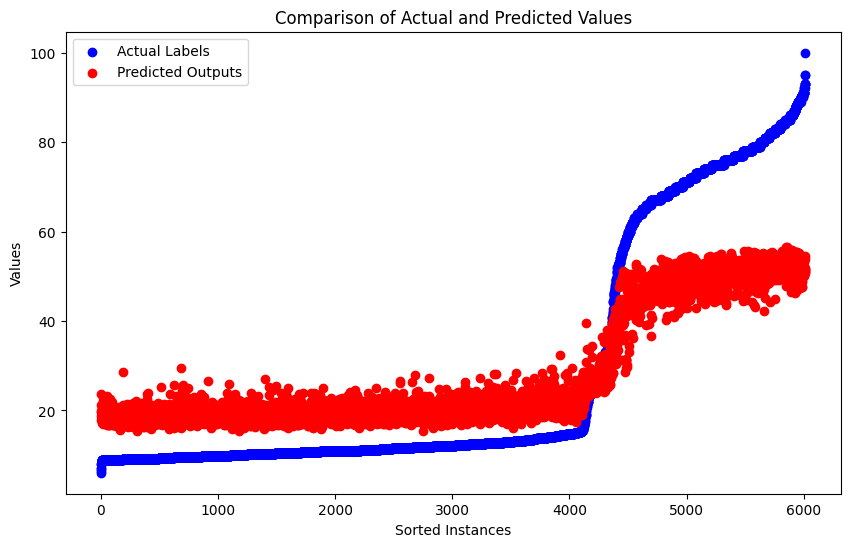

In [ ]:
import matplotlib.pyplot as plt
# Sort data by labels
sorted_indices = np.argsort(labels_list_train)
sorted_labels = np.array(labels_list_train)[sorted_indices]
sorted_outputs = np.array(outputs_list_train)[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sorted_labels)), sorted_labels, color='blue', label='Actual Labels')
plt.scatter(range(len(sorted_outputs)), sorted_outputs, color='red', label='Predicted Outputs')
plt.title('Comparison of Actual and Predicted Values - Training data')
plt.xlabel('Sorted Instances')
plt.ylabel('Values')
plt.legend()
plt.show()